In [51]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import tensorflow
import keras
import medmnist
from medmnist import INFO, Evaluator
import os
from tensorflow.keras.layers import Dense, Dropout, Flatten, Softmax, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Resizing
import medmnist.dataset as dt
from keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [52]:
gpus = tf.config.list_physical_devices()
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [53]:
tf.config.set_visible_devices(gpus[2], 'GPU')

In [54]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train/255
X_test = X_test/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [55]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 10))

In [56]:
X_train = tf.keras.applications.resnet50.preprocess_input(X_train)
X_test = tf.keras.applications.resnet50.preprocess_input(X_test)

In [57]:
X_train[0]

array([[[-103.69194118, -116.53586275, -123.44862745],
        [-103.76252941, -116.59860784, -123.51137255],
        [-103.77037255, -116.59076471, -123.48392157],
        ...,
        [-103.51547059, -116.26135294, -123.06039216],
        [-103.539     , -116.28880392, -123.08392157],
        [-103.53507843, -116.29272549, -123.09960784]],

       [[-103.86056863, -116.70056863, -123.6172549 ],
        [-103.939     , -116.779     , -123.68      ],
        [-103.939     , -116.74762745, -123.60941176],
        ...,
        [-103.72331373, -116.43390196, -123.19764706],
        [-103.74292157, -116.4535098 , -123.21333333],
        [-103.71547059, -116.43782353, -123.20156863]],

       [[-103.85664706, -116.68488235, -123.58196078],
        [-103.939     , -116.75154902, -123.6172549 ],
        [-103.90762745, -116.67311765, -123.48784314],
        ...,
        [-103.74292157, -116.44958824, -123.2172549 ],
        [-103.74292157, -116.44958824, -123.20941176],
        [-103.77429412

In [58]:
train_datagen = ImageDataGenerator(
        featurewise_center=True, 
        featurewise_std_normalization=True, 
        )

test_datagen = ImageDataGenerator(
        featurewise_center=True, 
        featurewise_std_normalization=True, 
        )

train_datagen.fit(X_train)
test_datagen.fit(X_test)

In [59]:
X_train.shape

(50000, 32, 32, 3)

In [60]:
n_classes = len(np.unique(y_train, axis=0))
n_classes

10

In [61]:
resnet50_model = ResNet50(weights="imagenet", input_shape=(32, 32, 3), include_top=False)

In [42]:
resnet50_model.trainable = True
for i in range(len(resnet50_model.layers)):
    resnet50_model.layers[i].trainable = False
    
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [43]:
for i, layer in enumerate(resnet50_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [44]:
transfer_model = keras.Sequential()

# transfer_model.add(Resizing(64,64))
transfer_model.add(resnet50_model)

transfer_model.add(Flatten())
transfer_model.add(Dense(1024, activation='relu', name='hidden1'))
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(512, activation='relu', name='hidden2'))
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(n_classes, activation='softmax', name='predictions'))

In [45]:
transfer_model.build((None,None,None,3))
transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)              

In [46]:
# inputs = keras.Input(shape=(32, 32, 3))
# x = model(inputs, training=False)
# x = Flatten()(x)
# # x = Dense(512, activation="relu")(x)
# # # x = Dropout(0.5)(x)
# # x = Dense(256, activation="relu")(x)
# # # pdb.set_trace()
# x = Dense(n_classes, activation="softmax")(x)
# # pdb.set_trace()
# transfer_model = keras.Model(inputs, x)
# transfer_model.summary()

In [47]:
transfer_model.compile(
    optimizer=keras.optimizers.RMSprop(0.001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
#     metrics=[keras.metrics.Accuracy()], # note that this direcyly compare y_out to y_true, without applying argmax
    metrics=['accuracy'] # while this considers the loss function
)

In [48]:
epochs = 15
x_padded = X_train #tf.image.resize_with_pad(X_train, 32, 32)
history = transfer_model.fit(train_datagen.flow(X_train, y_train, batch_size=64), epochs=epochs, shuffle=True, 
                             validation_data=test_datagen.flow(X_test, y_test))

Epoch 1/15
782/782 [==============================] - 17s 17ms/step - loss: 2.3696 - accuracy: 0.2845 - val_loss: 1.7073 - val_accuracy: 0.3914
Epoch 2/15
782/782 [==============================] - 12s 15ms/step - loss: 1.7253 - accuracy: 0.3916 - val_loss: 1.6567 - val_accuracy: 0.4216
Epoch 3/15
782/782 [==============================] - 12s 15ms/step - loss: 1.6335 - accuracy: 0.4224 - val_loss: 1.5962 - val_accuracy: 0.4366
Epoch 4/15
782/782 [==============================] - 12s 15ms/step - loss: 1.6080 - accuracy: 0.4286 - val_loss: 1.5741 - val_accuracy: 0.4368
Epoch 5/15
782/782 [==============================] - 12s 15ms/step - loss: 1.5805 - accuracy: 0.4421 - val_loss: 1.5827 - val_accuracy: 0.4378
Epoch 6/15
782/782 [==============================] - 12s 15ms/step - loss: 1.5646 - accuracy: 0.4494 - val_loss: 1.5993 - val_accuracy: 0.4285
Epoch 7/15
782/782 [==============================] - 12s 16ms/step - loss: 1.5510 - accuracy: 0.4554 - val_loss: 1.5832 - val_accuracy:

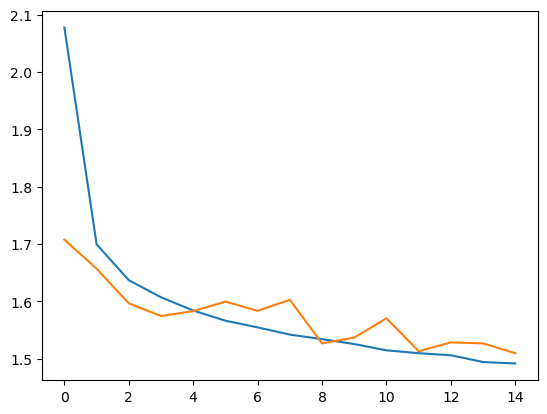

In [49]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

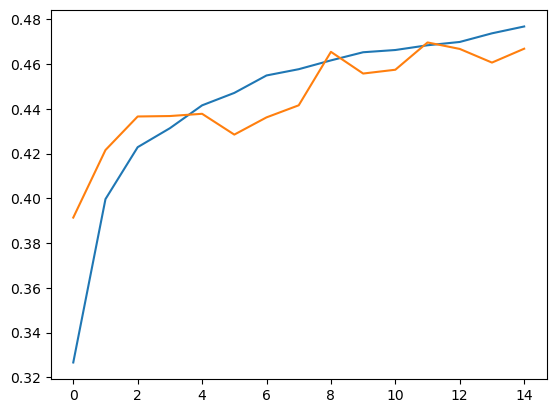

In [50]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])